# Data Task - César Núñez 

In [130]:
# pip install matplotlib
# pip install geopandas
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import geopandas as gdp
import folium as fm
from shapely.geometry import Point, LineString, Polygon

# 1.	Task 1: Candidacy in elections 

In [0]:
#Defining the working directory --- Change this directory in your computer
os.chdir("C:/Users/User/Documents/GitHub/CNHGitHub/programming-task-2023")

a.	Load in the delhi 2015 and 2020 election data (delhi-2015-2020-results)

In [5]:
#Loading the data
df = pd.read_csv("delhi-2015-2020-results.csv")

b.	For each election year, calculate the number of candidates for each assembly constituency (AC) in Delhi (there are 70 ACs so you should create a data frame that has the numbers of candidates for each of the 70 ACs in 2015 and 2020)

In [25]:
#First, we calculate the number of candidates for every AC
n_candidates = df.groupby(['Year','Constituency_No','Constituency_Name'])['Candidate'].count().reset_index()
#Now we transform the dataframe to a wide form, in order to be more usefull
n_candidates_ac = n_candidates.pivot_table(index='Constituency_No', columns='Year', values='Candidate').reset_index()

n_candidates_ac = n_candidates_ac.drop(2017, axis=1)

c.	Identify the top 5 ACs with the most candidates in 2015 and 2020. Produce a table with their AC number, name, and the number of candidates. 

In [31]:
#First, we identify the top 5 ACs with the most candidates for each year
top_5_2015 = n_candidates[n_candidates['Year']==2015].sort_values(by = 'Candidate', ascending=False).head(5)
top_5_2020 = n_candidates[n_candidates['Year']==2020].sort_values(by = 'Candidate', ascending=False).head(5)

#We generate a rank variable
top_5_2015['Rank'] = range(1, 6)
top_5_2020['Rank'] = range(1, 6)

#Now we combine both df to make one table 
top_5_final = pd.concat([top_5_2015, top_5_2020], ignore_index=True)
top_5_final.set_index(['Year', 'Rank'], inplace=True)

d.	Identify how many of the candidates in the top 5 constituencies for 2020 ran without a party label (these are candidates with the Party “IND” meaning independent) – if you look through the election-codebook you can get more information on what each variable means.

In [40]:
#First, we save the names of the top 5 Constituency_Name
top_5_2020_list = top_5_2020['Constituency_Name'].tolist()

candidates_2020 = df[df['Year']==2020]

conditions = {}
for i, const in enumerate(top_5_2020_list):
    conditions[f'cond_{i}'] = candidates_2020['Constituency_Name'] == const

candidates_top5_2020 = pd.concat([candidates_2020.loc[cond] for cond in conditions.values()], ignore_index=True)
top5_2020_ind = candidates_top5_2020[candidates_top5_2020['Party']=='IND']

n_candidates_ind = top5_2020_ind.groupby(['Year','Constituency_No','Constituency_Name'])['Candidate'].count().reset_index()

# 2.	Task 2: India Names

a.	Load in the India names sample dataset. This includes a random sample of voters names across the 70 ACs in Delhi. We are going to pretend for this exercise that these are all the voters in Delhi.

In [41]:
india_names = pd.read_csv('india-names-sample.csv')

b.	The India names sample dataset is incomplete. There are 70 ACs in Delhi but there are only 67 ACs in this dataset. Figure out which 3 ACs are missing

In [50]:
names_dataset_ac = india_names['ac_no'].unique()

missings_ac = set(range(1,71)) - set(names_dataset_ac)

print(f'The ACs that are missing in the data set are: {missings_ac}')

The ACs that are missing in the data set are: {40, 57, 38}


c.	We want to know if places that have more Muslim voters are more likely to have more independent candidates. Produce a scatter plot for 2015 and for 2020 where each dot is an AC and the x-axis is the percent of the population in that AC that is Muslim and the y-axis is the number of independent candidates in that AC. This task will involve merging data from the election dataset with the india names dataset.

In [79]:
#First we calculate for each AC the percent of population that is Muslim
muslim_pop = india_names.groupby(['ac_no'])['muslim'].mean().reset_index()

#Now we generate a df with the number of independent candidate for each AC and year
ind_candidates = df[df['Party'] == 'IND'].groupby(['Constituency_No','Year'])['Candidate'].count().reset_index()
ind_candidates = ind_candidates.pivot_table(index='Constituency_No', columns='Year', values='Candidate').reset_index()

ind_candidates.rename(columns = {'Constituency_No': 'ac_no'}, inplace = True)

#Now we merge both dataframes
df_scatter = pd.merge(muslim_pop, ind_candidates, how='left')
df_scatter.fillna(0, inplace=True)


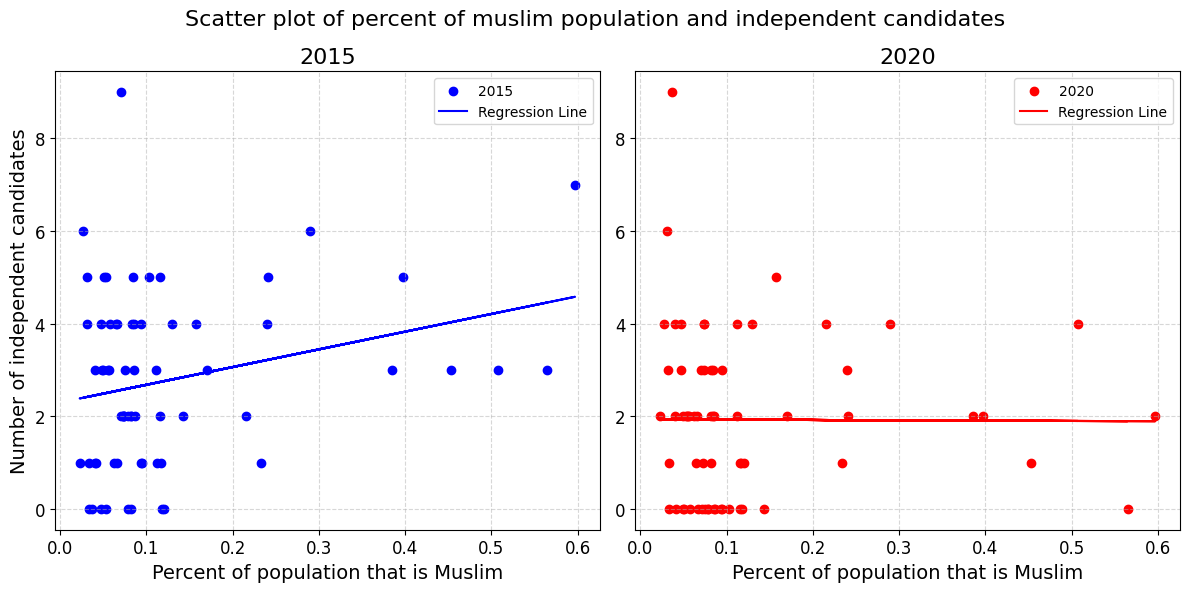

In [82]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.scatter(df_scatter['muslim'],df_scatter[2015], color='blue', label='2015')
coefficients = np.polyfit(df_scatter['muslim'], df_scatter[2015], 1)
regression_line = np.polyval(coefficients, df_scatter['muslim'])
plt.plot(df_scatter['muslim'], regression_line, color='blue', label='Regression Line')
plt.xlabel('Percent of population that is Muslim', fontsize=14)
plt.ylabel('Number of independent candidates', fontsize=14)
plt.title('2015', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(df_scatter['muslim'],df_scatter[2020], color='red', label='2020')
coefficients = np.polyfit(df_scatter['muslim'], df_scatter[2020], 1)
regression_line = np.polyval(coefficients, df_scatter['muslim'])
plt.plot(df_scatter['muslim'], regression_line, color='red', label='Regression Line')
plt.xlabel('Percent of population that is Muslim', fontsize=14)
plt.title('2020', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.suptitle('Scatter plot of percent of muslim population and independent candidates', fontsize=16)
plt.tight_layout()
plt.show()

d.	We want to look at how names have changed over time. Create a dataframe that identifies the average “voter_value” (this is the religiousity score for the voter in the dataset) for each year for both Muslims and Hindus (you will need to subset out any voters from other religious groups). 

In [91]:
muslim_names = india_names[india_names['religion'] == 'Muslim'].groupby(['birth_year', 'religion'])['voter_value'].mean().reset_index()
hindu_names = india_names[india_names['religion'] == 'Hindu'].groupby(['birth_year', 'religion'])['voter_value'].mean().reset_index()

df_names = pd.concat([muslim_names,hindu_names], ignore_index=True)

e.	Use that dataframe to create a figure where you plot a geom_smooth line (this is a function in the R package ggplot) with birth_year is the x axis and the average voter_value is the y-axis and the color of the line is the religious group. You do not have to use ggplot but if you do geom_smooth is the function you will want to use. 

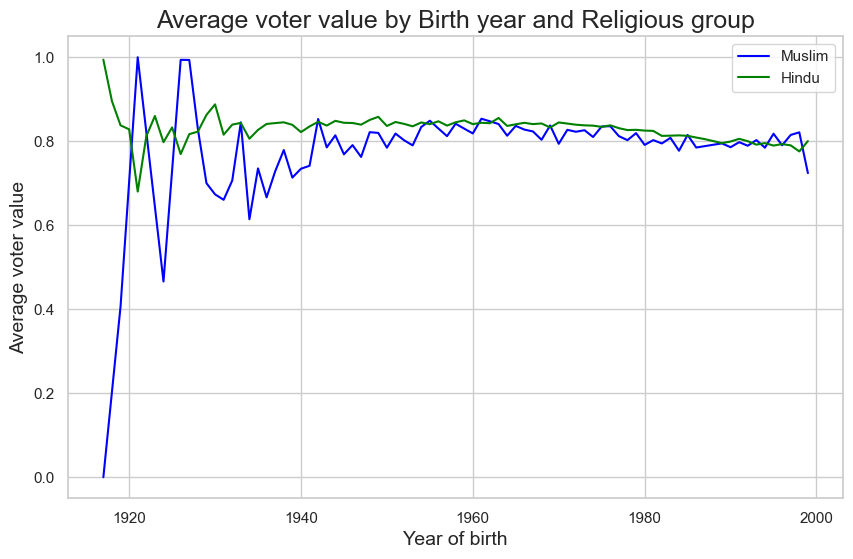

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(df_names[df_names['religion'] == 'Muslim'].birth_year, df_names[df_names['religion'] == 'Muslim'].voter_value, color='blue',label = "Muslim")
plt.plot(df_names[df_names['religion'] == 'Hindu'].birth_year, df_names[df_names['religion'] == 'Hindu'].voter_value, color='green', label = "Hindu")
plt.xlabel('Year of birth', fontsize=14)
plt.ylabel('Average voter value', fontsize=14)
plt.legend()
plt.title('Average voter value by Birth year and Religious group', fontsize=18)
plt.show()

# 3.	Task 3: Spatial

a.	For the state of Delhi, merge the number of candidates for each constituency in the most recent election (2020) with the constituency shapefile and make a choropleth map. 

In [122]:
n_candidates_2020 = n_candidates[n_candidates['Year']==2020]
n_candidates_2020.rename(columns = {'Constituency_No': 'AC_NO'}, inplace = True)

delhi_shp = gdp.read_file(f'../programming-task-2023/delhi-ac-map/delhi-ac.shp')

merged_data = delhi_shp.merge(n_candidates_2020, on='AC_NO', how='inner')

lat_inicial = 28.62520313980244
long_inicial = 77.16813174950018
zoom_start = 10

z = fm.Map(location = [lat_inicial, long_inicial], tiles='cartodbpositron', zoom_start = zoom_start)

fm.Choropleth(
    geo_data=delhi_shp,
    data=n_candidates_2020,
    columns=['AC_NO', 'Candidate'],
    key_on="feature.properties.AC_NO",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name="Number of candidates",
    smooth_factor=0,
    Highlight= True,
    line_color = "#0000",
    overlay=True,
    nan_fill_color = "White"  # fill white missing values 
).add_to(z)

z

C:\Users\User\AppData\Local\Temp\ipykernel_11308\4212705068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_candidates_2020.rename(columns = {'Constituency_No': 'AC_NO'}, inplace = True)


b.	For one constituency of your choice, identify the centroid of the constituency and draw a straight line passing by the centroid and perpendicular to the geographic north. This line will cut the constituency in a northern and a southern half.

C:\Users\User\AppData\Local\Temp\ipykernel_11308\4220474738.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = const_7['geometry'].centroid.iloc[0]


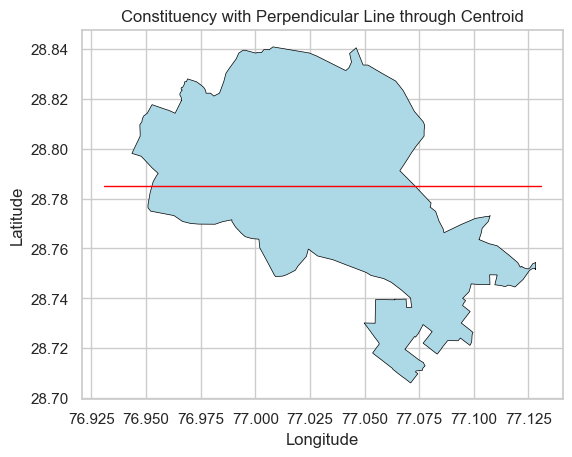

In [128]:
const_7 = delhi_shp[delhi_shp['AC_NO'] == 7]

centroid = const_7['geometry'].centroid.iloc[0]

centroid_point = Point(centroid.x, centroid.y)

perpendicular_line = LineString([(centroid.x  - 0.1, centroid.y), (centroid.x+ 0.1, centroid.y)])

fig, ax = plt.subplots(1, 1)
const_7.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.5)
ax.plot(*perpendicular_line.xy, color='red', linewidth=1)
ax.set_title('Constituency with Perpendicular Line through Centroid')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

c.	Calculate the area of the constituency in the southern half (bottom). 

In [157]:
frontera_7 = const_7['geometry'].boundary

AttributeError: 'MultiPoint' object has no attribute 'y'